# 

https://www.kaggle.com/datasets/behrad3d/nasa-cmaps/data 

# Scenario 01: Anomaly Detection

In [ ]:
import pandas as pd

index_names = ['Unit', 'Cycle']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = ['sensor_' + str(i) for i in range(1, 21)]

column_names = index_names + setting_names + sensor_names

# Load data
data = pd.read_csv(
    '../data/raw/train_FD001.txt',
      sep='\s+', 
      header=None, 
      index_col=False, 
      names=column_names,
      )

In [ ]:
# Visualize data
data.head()

In [ ]:
import matplotlib.pyplot as plt

# Plot sensor data for unit 1
data[data["Unit"]==1][data.columns[5:]].plot(subplots=True, figsize=(7, 10), layout=(9, 3))


In [ ]:
# Drop columns with constant values
data = data.drop(columns=['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'])

In [ ]:
# List with unique units
units_ = data["Unit"].unique()

# Loop over units
for unit in units_:
    # Add the Moving Average to every sensor 
    data.loc[data["Unit"]==unit, data.columns[2:]] = data.loc[data["Unit"]==unit, data.columns[2:]].rolling(window=5).mean()

# Remove NaN values
data = data.dropna() 

# Reset index
data = data.reset_index(drop=True)

# Display the first 10 rows
data.head(10)           


In [ ]:
# Plot sensor data for unit 1
for i in range(1, 20, 4):
    data[data["Unit"]==i][data.columns[5:]].plot(subplots=True, figsize=(7, 10), layout=(9, 3))

In [ ]:
# Count max cycle per unit
max_cycle = data.groupby('Unit')['Cycle'].max()

# Count plot
max_cycle.plot(kind='hist', bins=10)


In [ ]:
# Plot all units
data[data.columns[5:]].plot(subplots=True, figsize=(10, 10), layout=(9, 3))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Drop cycle, unit, and settings columns
X = data.drop(columns=['Unit', 'Cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'])

# Standardize data
scaler = MinMaxScaler()

# Fit and transform data
X_scaled = scaler.fit_transform(X)

# Create a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the first 10 rows
X_scaled.head(10)

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# PCA
pca = PCA(n_components=2)

# Fit and transform data
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame
X_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# Explained variance
explained_variance = pca.explained_variance_ratio_


In [ ]:
import numpy as np

fig, ax1 = plt.subplots()

individual_var_explained = explained_variance / explained_variance.sum() * 100
cumulative_var_explained = np.cumsum(individual_var_explained)

ax1.plot(individual_var_explained[:10], 'o', markersize=8, label='Individual')
ax1.plot(cumulative_var_explained[:10], 'o', markersize=8, label='Cumulative')
ax1.set_xlabel('# of principal component')
ax1.set_ylabel('% of variance of dataset explained')
ax1.set_title('Individual and Cumulative Variance Explained by PCA')
ax1.legend()
ax1.grid(True)

In [ ]:
# Plot PCA
sns.scatterplot(x='PC1', y='PC2', data=X_pca)

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming data and X_pca are pandas DataFrames
# data should contain a 'Unit' column
# X_pca should contain 'PC1' and 'PC2' columns corresponding to the PCA results

# Find first and last point for each engine
idxEngFirst = data.groupby('Unit').head(1).index
idxEngLast = data.groupby('Unit').tail(1).index

# Create a combined index of first and last points
idxEngCombined = idxEngFirst.union(idxEngLast)

# Subset the PCA data for first and last points
X_pca_first_last = X_pca.loc[idxEngCombined]
data_first_last = data.loc[idxEngCombined]

# Separate data for first and last points
X_pca_first = X_pca.loc[idxEngFirst]
X_pca_last = X_pca.loc[idxEngLast]

# Plot PCA with the first and last points of each engine
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=X_pca, hue=data['Unit'], palette='tab10', alpha=0.3, legend=False)
sns.scatterplot(x='PC1', y='PC2', data=X_pca_first, color='blue', s=100, edgecolor='k', label='First Points')
sns.scatterplot(x='PC1', y='PC2', data=X_pca_last, color='red', s=100, edgecolor='k', label='Last Points')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First and Last Points for Each Unit')
plt.legend(title='Points')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

# Assuming data and X_pca are pandas DataFrames
# data should contain a 'Unit' column
# X_pca should contain 'PC1' and 'PC2' columns corresponding to the PCA results

# Find first and last point for each engine
idxEngFirst = data.groupby('Unit').head(1).index
idxEngLast = data.groupby('Unit').tail(1).index

# Create labels for first and last points
labels = np.concatenate([np.zeros(len(idxEngFirst)), np.ones(len(idxEngLast))])

# Combine first and last points
X_combined = pd.concat([X_pca.loc[idxEngFirst], X_pca.loc[idxEngLast]])
y_combined = pd.Series(labels, index=X_combined.index)

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_combined[['PC1', 'PC2']], y_combined)

# Define the decision boundary
coef = model.coef_[0]
intercept = model.intercept_

# Plot PCA with the first and last points of each engine
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=X_pca, hue=data['Unit'], palette='tab10', alpha=0.3, legend=False)
sns.scatterplot(x='PC1', y='PC2', data=X_pca.loc[idxEngFirst], color='blue', s=100, edgecolor='k', label='First Points')
sns.scatterplot(x='PC1', y='PC2', data=X_pca.loc[idxEngLast], color='red', s=100, edgecolor='k', label='Last Points')

# Plot decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contour(xx, yy, Z, levels=[0], colors='k', linestyles='--')

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First and Last Points for Each Unit with Decision Boundary')
plt.legend(title='Points')
plt.grid(True)
plt.show()


# Scenario 02: Classification

In [ ]:
import pandas as pd

index_names = ['Unit', 'Cycle']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = ['sensor_' + str(i) for i in range(1, 22)]

column_names = index_names + setting_names + sensor_names

# Load train data
train_data = pd.read_csv(
    '../data/raw/train_FD001.txt',
      sep='\s+', 
      header=None, 
      index_col=False, 
      names=column_names,
      )

# Load test data
test_data = pd.read_csv(
    '../data/raw/test_FD001.txt',
      sep='\s+', 
      header=None, 
      index_col=False, 
      names=column_names,
      )

In [ ]:
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')


In [ ]:
import pandas as pd

# Drop columns with constant values
test_data = test_data.drop(columns=['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'])
train_data = train_data.drop(columns=['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'])

# List with unique units
units_ = test_data["Unit"].unique()

# Loop over units to add the Moving Average to every sensor 
for unit in units_:
    test_data.loc[test_data["Unit"] == unit, test_data.columns[2:]] = test_data.loc[test_data["Unit"] == unit, test_data.columns[2:]].rolling(window=5).mean()
    train_data.loc[train_data["Unit"] == unit, train_data.columns[2:]] = train_data.loc[train_data["Unit"] == unit, train_data.columns[2:]].rolling(window=5).mean()

# Remove NaN values
test_data = test_data.dropna() 
train_data = train_data.dropna()

# Reset index
test_data = test_data.reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

# Function to classify urgency based on max cycle per unit
def classify_urgency(df):
    max_cycle_per_unit = df.groupby('Unit')['Cycle'].max()
    def urgency_label(row):
        max_cycle = max_cycle_per_unit[row['Unit']]
        return 1 if row['Cycle'] >= (max_cycle - 50) else 0
    df['category'] = df.apply(urgency_label, axis=1)
    return df

# Apply the function to both test and train datasets
test_data = classify_urgency(test_data)
train_data = classify_urgency(train_data)

# Drop unit and settings columns
test_data = test_data.drop(columns=['Unit'])
train_data = train_data.drop(columns=['Unit'])


In [ ]:
sns.scatterplot(x='Cycle', y='sensor_2', data=train_data, hue='category', palette='tab10')

In [ ]:
# Drop Cycle column
test_data = test_data.drop(columns=['Cycle'])
train_data = train_data.drop(columns=['Cycle'])

In [ ]:
# Display the first 10 rows
test_data.head(10)

# Class distribution
train_data['category'].value_counts()

In [ ]:
# Display the first 10 rows
train_data.head(10)

In [ ]:
from sklearn.preprocessing import StandardScaler
# X_test and y_test
X_test = test_data.drop(columns=['category'])
X_train = train_data.drop(columns=['category'])
y_test = test_data['category']
y_train = train_data['category']

# Standardize data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

# Create a DataFrame
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Fit a logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predict the categories
y_pred = model.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred))



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, categories):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest model
model = RandomForestClassifier()
model.fit(X_train_scaled, y_train)

# Predict the categories
y_pred = model.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred, [0, 1])

In [ ]:
# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

# Fit a KNN model
model = KNeighborsClassifier()

# Fit the model
model.fit(X_train_scaled, y_train)

# Predict the categories
y_pred = model.predict(X_test_scaled)

# Classification report
print(classification_report(y_test, y_pred))


# Scenario 03: Regression

In [24]:
import pandas as pd

index_names = ['Unit', 'Cycle']
setting_names = ['op_setting_1', 'op_setting_2', 'op_setting_3']
sensor_names = ['sensor_' + str(i) for i in range(1, 22)]

column_names = index_names + setting_names + sensor_names

# Load train data
data = pd.read_csv(
    '../data/raw/train_FD001.txt',
      sep='\s+', 
      header=None, 
      index_col=False, 
      names=column_names,
      )


In [25]:
data.head()

,Unit,Cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


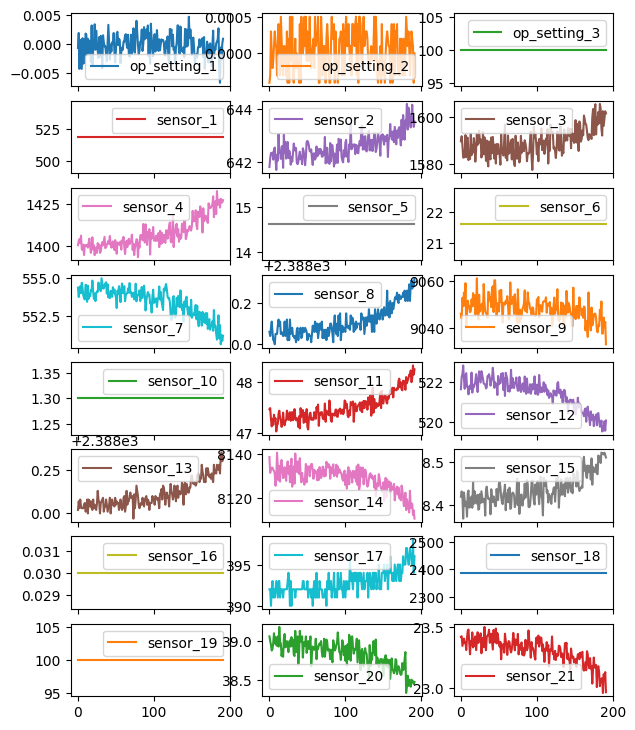

In [26]:
import matplotlib.pyplot as plt

data_unit = data[data["Unit"]==1][data.columns[2:]].plot(subplots=True, figsize=(7, 10), layout=(9, 3))


In [27]:
import pandas as pd

# Drop columns with constant values
data = data.drop(columns=['op_setting_3','sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19'])

# Display the first 10 rows
data.head(10)


,Unit,Cycle,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_9,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
5,1,6,-0.0043,-0.0001,642.10,1584.47,1398.37,554.67,2388.02,9049.68,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669
6,1,7,0.0010,0.0001,642.48,1592.32,1397.77,554.34,2388.02,9059.13,47.36,522.32,2388.03,8132.32,8.3974,392,39.10,23.3774
7,1,8,-0.0034,0.0003,642.56,1582.96,1400.97,553.85,2388.00,9040.80,47.24,522.47,2388.03,8131.07,8.4076,391,38.97,23.3106
8,1,9,0.0008,0.0001,642.12,1590.98,1394.80,553.69,2388.05,9046.46,47.29,521.79,2388.05,8125.69,8.3728,392,39.05,23.4066
9,1,10,-0.0033,0.0001,641.71,1591.24,1400.46,553.59,2388.05,9051.70,47.03,521.79,2388.06,8129.38,8.4286,393,38.95,23.4694


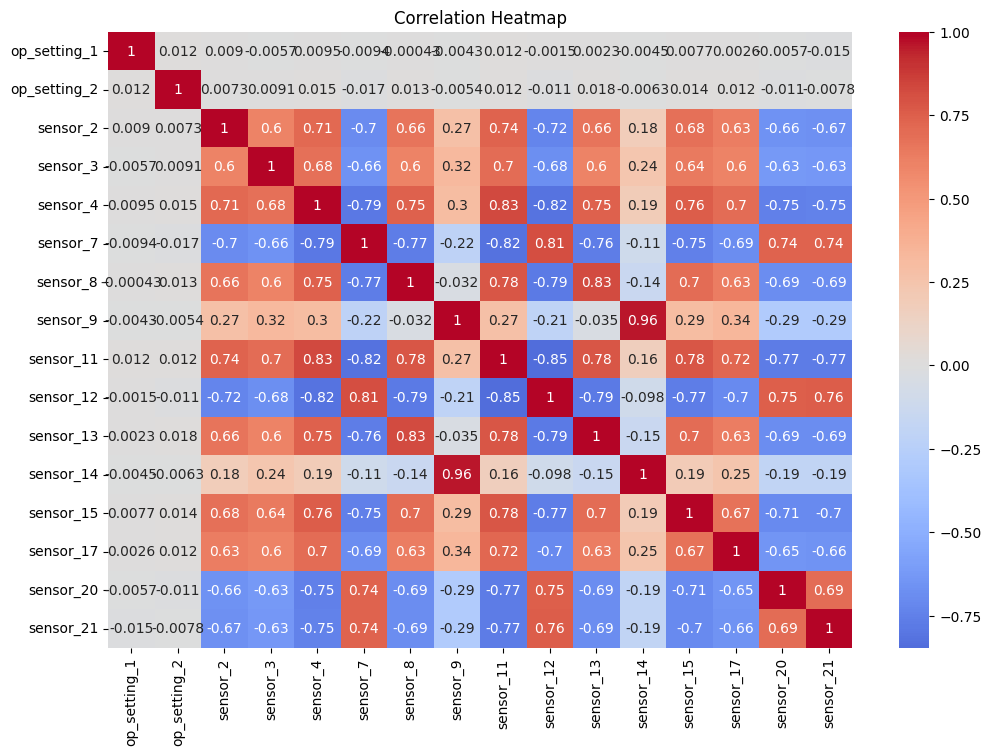

In [29]:
import seaborn as sns

# Verify correlation
corr = data[data.columns[2:]].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)
plt.title('Correlation Heatmap')
plt.show()


In [30]:
# Drop correlated columns
data = data.drop(columns=['sensor_9'])

In [31]:
# Function to calculate RUL
def calculate_rul(df):
    max_cycle_per_unit = df.groupby('Unit')['Cycle'].max()
    def rul(row):
        max_cycle = max_cycle_per_unit[row['Unit']]
        return max_cycle - row['Cycle']
    df['RUL'] = df.apply(rul, axis=1)
    return df

# Apply the function to both test and train datasets
data = calculate_rul(data)

# Display the first 10 rows
data.head(10)

,Unit,Cycle,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191.0
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190.0
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189.0
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188.0
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187.0
5,1,6,-0.0043,-0.0001,642.10,1584.47,1398.37,554.67,2388.02,47.16,521.68,2388.03,8132.85,8.4108,391,38.98,23.3669,186.0
6,1,7,0.0010,0.0001,642.48,1592.32,1397.77,554.34,2388.02,47.36,522.32,2388.03,8132.32,8.3974,392,39.10,23.3774,185.0
7,1,8,-0.0034,0.0003,642.56,1582.96,1400.97,553.85,2388.00,47.24,522.47,2388.03,8131.07,8.4076,391,38.97,23.3106,184.0
8,1,9,0.0008,0.0001,642.12,1590.98,1394.80,553.69,2388.05,47.29,521.79,2388.05,8125.69,8.3728,392,39.05,23.4066,183.0
9,1,10,-0.0033,0.0001,641.71,1591.24,1400.46,553.59,2388.05,47.03,521.79,2388.06,8129.38,8.4286,393,38.95,23.4694,182.0


In [32]:
# Feature extraction
unit_list = data['Unit'].unique()

for unit in unit_list:
    # Exponential moving average
    data.loc[data['Unit']==unit, data.columns[2:]] = data.loc[data['Unit']==unit, data.columns[2:]].ewm(span=5).mean()

    # Fill NaN with mean
    data.loc[data['Unit']==unit, data.columns[2:-1]] = data.loc[data['Unit']==unit, data.columns[2:]].fillna(data.loc[data['Unit']==unit, data.columns[2:]].mean())

# Display the first 10 rows
data.head(10)

/var/folders/49/pdpmsz1x33g_s0glp3s0b0wh0000gn/T/ipykernel_73212/1205760948.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[392.         392.         391.05263158 391.44615385 392.04265403
 391.66165414 391.7814473  391.51038858 391.67795107 392.12641103
 392.08378118 391.7197148  392.14868066 392.43342917 391.9545258
 391.96970698 391.97981491 391.98654783 391.65755014 391.77173443
 391.84783821 391.89856559 391.93238007 391.95492139 392.30329472
 392.86887808 392.91258616 391.94171271 392.2944779  391.52964795
 391.68643251 391.79095525 391.86063694 391.90709134 391.60472735
 391.73648496 391.82432334 391.88288224 391.9219215  391.94794767
 391.96529845 391.97686563 391.98457709 391.98971806 392.32647871
 392.55098581 392.36732387 392.24488258 392.16325505 392.1088367
 392.40589114 391.93726076 391.95817384 391.97211589 391.98141059
 391.65427373 391.76951582 391.17967721 391.45311814 391.96874543

,Unit,Cycle,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
0,1,1,-0.000700,-0.000400,641.820000,1589.700000,1400.600000,554.360000,2388.060000,47.470000,521.660000,2388.020000,8138.620000,8.419500,392.000000,39.060000,23.419000,191.000000
1,1,2,0.000860,-0.000340,642.018000,1590.972000,1402.124000,553.994000,2388.048000,47.482000,522.032000,2388.050000,8134.342000,8.426880,392.000000,39.024000,23.421760,190.400000
2,1,3,-0.001584,-0.000037,642.175263,1589.559474,1403.107368,554.120000,2388.063158,47.381579,522.215789,2388.040526,8133.815263,8.422579,391.052632,38.988947,23.385021,189.736842
3,1,4,-0.000635,-0.000022,642.247846,1586.747538,1402.593385,554.257077,2388.082615,47.277077,522.483385,2388.056923,8133.821385,8.399991,391.446154,38.943692,23.380402,189.015385
4,1,5,-0.001121,-0.000090,642.294739,1585.251327,1403.985592,554.158389,2388.073934,47.278199,522.370758,2388.050427,8133.813175,8.411281,392.042654,38.926919,23.389614,188.241706
5,1,6,-0.002283,-0.000094,642.223579,1584.965820,1401.933579,554.345338,2388.054226,47.235008,522.118346,2388.042962,8133.461218,8.411105,391.661654,38.946316,23.381314,187.422556
6,1,7,-0.001120,-0.000025,642.314366,1587.569607,1400.459441,554.343448,2388.042108,47.279262,522.189743,2388.038373,8133.057164,8.406253,391.781447,39.000729,23.379928,186.564837
7,1,8,-0.001911,0.000088,642.399569,1585.970684,1400.636538,554.172287,2388.027502,47.265643,522.286955,2388.035469,8132.367881,8.406720,391.510389,38.990070,23.355881,185.675178
8,1,9,-0.000983,0.000092,642.303890,1587.685050,1398.639066,554.007231,2388.035202,47.273979,522.116879,2388.040442,8130.082472,8.395111,391.677951,39.010580,23.373239,184.759637
9,1,10,-0.001769,0.000095,642.102433,1588.890946,1399.256756,553.865700,2388.040221,47.191217,522.005997,2388.047076,8129.844182,8.406471,392.126411,38.990030,23.405858,183.823524


array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

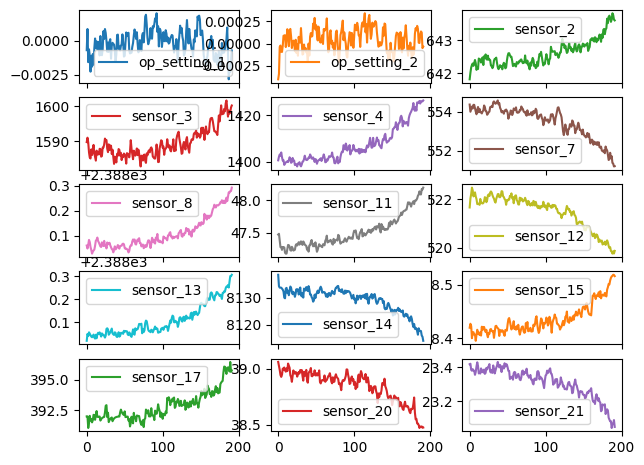

In [33]:
# Plot sensors data for unit 1
data[data["Unit"]==1][data.columns[2:-1]].plot(subplots=True, figsize=(7, 10), layout=(9, 3))



In [34]:
# Drop Cycle column
data = data.drop(columns=['Cycle'])

In [35]:
# X_test and y_test
X = data.drop(columns=['RUL'])
y = data['RUL']


In [36]:
# train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'Train data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Train data shape: (16504, 16)
Test data shape: (4127, 16)


In [37]:
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)
X_train_scaled = scaler.fit_transform(X_train)

# Create a DataFrame
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

In [38]:
X_train_scaled.head()

,Unit,op_setting_1,op_setting_2,sensor_2,sensor_3,sensor_4,sensor_7,sensor_8,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21
0,-0.666020,-0.130967,-1.888528,-0.064400,0.293834,-0.202314,-0.357365,0.844464,-0.354807,0.022157,0.214493,-0.683799,-0.127575,0.187200,-0.040035,0.182187
1,-0.120098,0.444475,0.763901,-0.968973,-0.540811,-1.110061,1.039534,-1.173565,-0.837198,1.379456,-1.026705,0.603647,-1.161294,-1.057571,0.808879,0.821957
2,-0.700140,-1.548604,-0.668781,-0.915079,-1.259166,-0.844236,0.568762,-0.895400,-0.947263,0.972220,-0.386449,-0.292503,-1.161774,-0.624101,0.861717,0.612271
3,0.937624,-1.778381,-1.226553,-0.663586,-1.483034,-1.038795,1.243666,-0.928691,-1.232347,1.375814,-1.153132,-0.075033,-0.836909,-0.935418,1.050356,1.618651
4,1.449426,-0.635011,0.767190,0.182972,-0.116247,-0.026747,-0.079752,0.854821,0.112109,-0.088887,0.678150,-0.826654,-0.060408,0.034162,-0.053857,-0.128283


In [39]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Fit a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X_train_scaled, y_train)

# Predict the RUL
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

# R2 score
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

# RMSE
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

# MAE
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)


print(f'R2 score (test): {r2_test}')
print(f'R2 score (train): {r2_train}')
print(f'RMSE (test): {rmse_test}')
print(f'RMSE (train): {rmse_train}')
print(f'MAE (test): {mae_test}')
print(f'MAE (train): {mae_train}')


R2 score (test): 0.5846611433172779
R2 score (train): 0.6012027642392218
RMSE (test): 43.52026805949488
RMSE (train): 43.66104077890923
MAE (test): 33.31577519539557
MAE (train): 33.359896341556315


/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
# SVM
from sklearn.svm import SVR

# Fit a SVM model
model = SVR()

# Fit the model
model.fit(X_train_scaled, y_train)

# Predict the RUL
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

# Calculate the mean absolute error
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calculate the root mean squared error
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

# Calculate the R2 score
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f'R2 score (test): {r2_test}')
print(f'R2 score (train): {r2_train}')
print(f'RMSE (test): {rmse_test}')
print(f'RMSE (train): {rmse_train}')
print(f'MAE (test): {mae_test}')
print(f'MAE (train): {mae_train}')


R2 score (test): 0.6244416337373022
R2 score (train): 0.6425230644773596
RMSE (test): 41.38366985269749
RMSE (train): 41.337292464820884
MAE (test): 28.692956342221514
MAE (train): 28.31622591059823


/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

# Fit a random forest model
model = RandomForestRegressor()

# Fit the model
model.fit(X_train_scaled, y_train)

# Predict the RUL
y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

# Calculate the mean absolute error
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calculate the root mean squared error
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

# Calculate the R2 score
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f'R2 score (test): {r2_test}')
print(f'R2 score (train): {r2_train}')
print(f'RMSE (test): {rmse_test}')
print(f'RMSE (train): {rmse_train}')
print(f'MAE (test): {mae_test}')
print(f'MAE (train): {mae_train}')

R2 score (test): 0.8758124455113576
R2 score (train): 0.9884686009760866
RMSE (test): 23.797389431949785
RMSE (train): 7.424359869372144
MAE (test): 15.643678771988634
MAE (train): 5.156379320186254


/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Fit a random forest model
model = RandomForestRegressor()

# Grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
grid_search.best_params_

# Predict the RUL
y_pred_test = grid_search.predict(X_test_scaled)
y_pred_train = grid_search.predict(X_train_scaled)

# Calculate the mean absolute error
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calculate the root mean squared error
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)

# Calculate the R2 score
r2_test = r2_score(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)

print(f'R2 score (test): {r2_test}')
print(f'R2 score (train): {r2_train}')
print(f'RMSE (test): {rmse_test}')
print(f'RMSE (train): {rmse_train}')
print(f'MAE (test): {mae_test}')
print(f'MAE (train): {mae_train}')


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  22.9s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  23.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  22.0s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  45.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  45.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  22.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  45.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.1min
[CV] END max_depth=10, min_sa

/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  52.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  52.7s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 1.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=  52.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  26.1s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  25.3s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=  25.4s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 1.3min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total 

/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/fontana/opt/miniconda3/envs/bi/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


# Scenario 4: Survival Analysis
https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d 

https://hex.tech/blog/autoencoders-for-feature-selection/ 

https://www.kaggle.com/code/triarahmatmauludin/survival-analysis-for-predictive-maintenance

https://www.mathworks.com/content/dam/mathworks/ebook/estimating-remaining-useful-life-ebook.pdf

https://www.youtube.com/watch?v=7_XK7mGMm1E&list=PLoROMvodv4rPP6braWoRt5UCXYZ71GZIQ&index=84 
